In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from core.model_tester import ModelTester
from core.categorizer import Categorizer
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

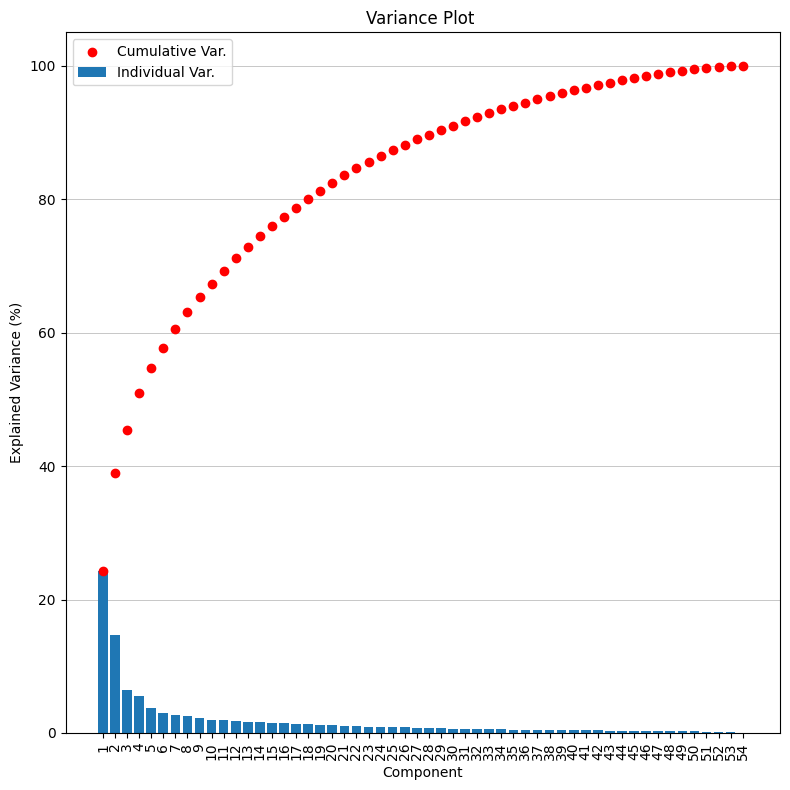

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


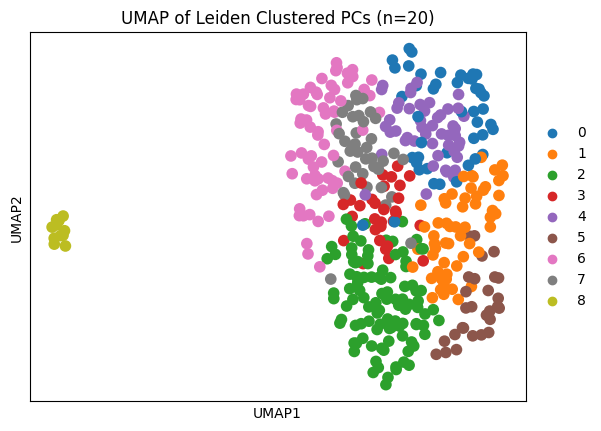

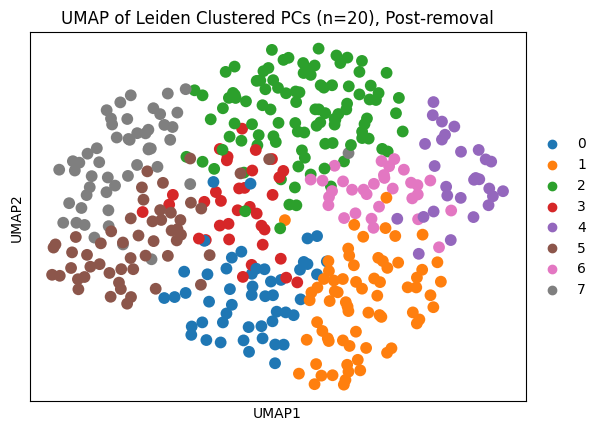

In [2]:
pp = Preprocessor()
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')
ct_counts_metadata = ct_counts_metadata[:, ct_counts_metadata.var_names != 'Exc RELN CHD7']

In [3]:
# Process data into the regression df
data = pd.DataFrame(ct_counts_metadata.X, columns=ct_counts_metadata.var.index, index=ct_counts_metadata.obs.index)
data['educ'] = ct_counts_metadata.obs['educ']
data = data.dropna(axis=0, how='any')

In [4]:
# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from io import StringIO

pvalues = np.zeros(len(ct_counts_metadata.var_names))
for i, cell_type in enumerate(ct_counts_metadata.var_names):
    m = smf.ols(f'Q("{cell_type}") ~ educ', data=data).fit()
    csv = StringIO(m.summary().tables[1].as_csv())
    df = pd.read_csv(csv)
    pvalues[i] = df.iloc[1, 4]

In [5]:
pvalues_sqrt = np.zeros(len(ct_counts_metadata.var_names))
for i, cell_type in enumerate(ct_counts_metadata.var_names):
    m = smf.ols(f'Q("{cell_type}") ~ np.sqrt(educ)', data=data).fit()
    csv = StringIO(m.summary().tables[1].as_csv())
    df = pd.read_csv(csv)
    pvalues_sqrt[i] = df.iloc[1, 4]

/tmp/ipykernel_157821/2483359551.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_157821/2483359551.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


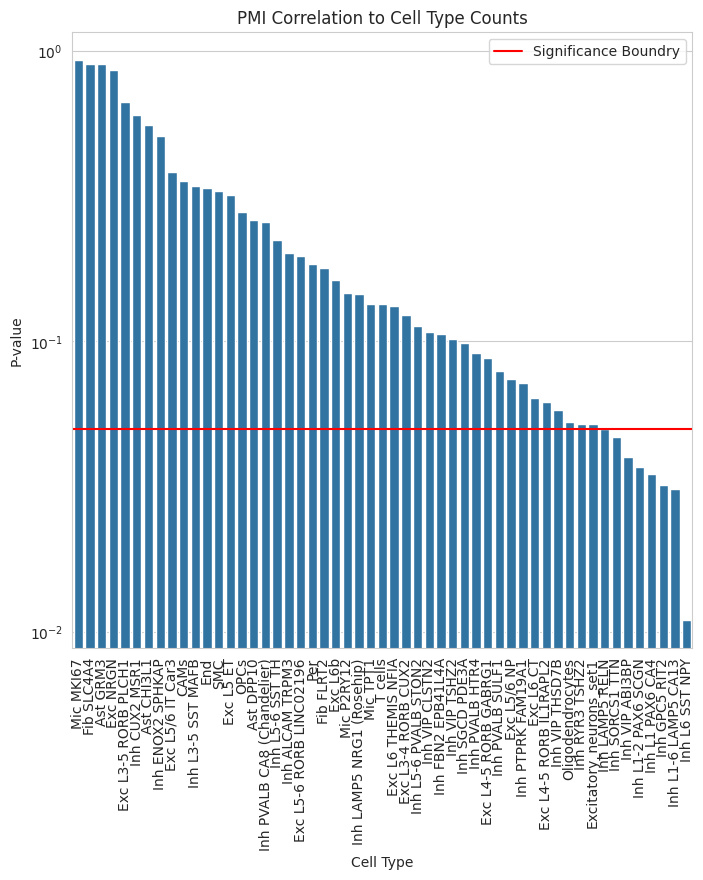

In [6]:
import seaborn as sns

pvalue_df = pd.DataFrame({'pvalue': pvalues, 'sqrt_pvalue': pvalues_sqrt, 'celltype': ct_counts_metadata.var_names})

sns.set_style('whitegrid')
barplot = sns.barplot(x='celltype', y='pvalue', data=pvalue_df, order=pvalue_df.sort_values(by='pvalue', ascending=False).celltype)
barplot.set_yscale('log')
barplot.set_ylabel('P-value')
barplot.set_xlabel('Cell Type')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
barplot.axhline(0.05, c='red', label='Significance Boundry')
barplot.legend()
barplot.set_title('PMI Correlation to Cell Type Counts')
barplot.figure.set_size_inches(8,8)
barplot.figure.show()

/tmp/ipykernel_157821/1184474339.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_157821/1184474339.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


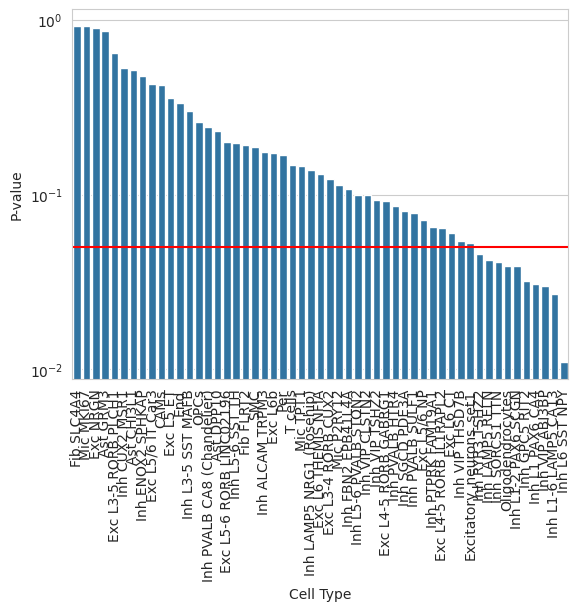

In [7]:
barplot = sns.barplot(x='celltype', y='sqrt_pvalue', data=pvalue_df, order=pvalue_df.sort_values(by='sqrt_pvalue', ascending=False).celltype)
barplot.set_yscale('log')
barplot.set_ylabel('P-value')
barplot.set_xlabel('Cell Type')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
barplot.axhline(0.05, c='red')
barplot.figure.show()

In [8]:
ct_counts_metadata.obs

,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID,projid
projid,,,,,,,,,,,,,,,,,,
1211411,ROS,1.0,12.0,1.0,2.0,NaN,85.248459958932244,NaN,85.549623545516766,NaN,24.0,6.500000,1.0,4.0,4.0,4.0,R2626559,1211411
2899847,MAP,1.0,14.0,1.0,2.0,33.0,73.489390828199859,NaN,74.450376454483234,NaN,27.0,7.016667,2.0,2.0,3.0,3.0,R9936070,2899847
3713990,MAP,1.0,12.0,1.0,2.0,33.0,87.668720054757017,NaN,87.928815879534568,NaN,30.0,4.333333,4.0,2.0,1.0,1.0,R2367199,3713990
3889845,MAP,0.0,13.0,1.0,2.0,34.0,90+,NaN,90+,NaN,22.0,6.916667,2.0,1.0,2.0,2.0,R9891381,3889845
6107196,MAP,1.0,15.0,1.0,2.0,33.0,90+,NaN,90+,NaN,22.0,4.166667,5.0,1.0,4.0,4.0,R9033345,6107196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94974890,MAP,0.0,12.0,1.0,2.0,33.0,77.700205338809042,NaN,78.190280629705683,NaN,27.0,7.083333,1.0,2.0,2.0,2.0,R9507497,94974890
95491648,MAP,1.0,19.0,1.0,2.0,33.0,85.587953456536624,NaN,85.796030116358665,NaN,27.0,5.583333,3.0,4.0,1.0,1.0,R5259690,95491648
95919181,MAP,1.0,16.0,1.0,2.0,33.0,85.352498288843265,NaN,85.826146475017111,NaN,28.0,3.250000,3.0,2.0,2.0,2.0,R1977848,95919181
